In [2]:
import tensorflow as tf

from google.colab import drive

import cv2

from glob import glob
import numpy as np
import os

import keras
import keras.backend as K
import keras.engine as KE
import keras.models as KM
import keras.layers as layers
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random

from tensorflow.python.ops import math_ops

from skimage import measure

import sys

SIZE = 1024

In [45]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Segmentation/lib')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [300]:

import images
import utils
import datasets

In [301]:
import importlib
importlib.reload(images)
importlib.reload(utils)
importlib.reload(datasets)

<module 'datasets' from '/content/drive/MyDrive/Segmentation/lib/datasets.py'>

In [7]:
## Test code below this line
bboxes1 = tf.convert_to_tensor(np.array([[0., 0, 10, 10], [1., 1, 10, 10], [20, 20, 30, 30]]))
bboxes2 = tf.convert_to_tensor(np.array(
    [[-2., -2, -1, -1],
     [1, 1, 2 ,2],
     [-1, -1, 1, 1],
     [9, 9, 11, 11],
     [11, 11, 12, 12],
     [0.5, 0.5, 10, 10],
     [-0.5, -0.5, 10, 10]
     ]
))

x = utils.iou(bboxes1, bboxes2)

## The following calls use expected input sizes for anchors and ground truth
## boxes 
bb1 = tf.random.uniform([100000, 4])
bb2 = tf.random.uniform([100, 4])
## load test. It is pretty amazing that this returns instantly.
x = utils.iou(bb1, bb2)

utils.anchor_gt_assignment(bboxes1, bboxes2, 100)
utils.anchor_gt_assignment(bb1, bb2, 100)

(<tf.Tensor: shape=(100, 2), dtype=int32, numpy=
 array([[80838,    99],
        [97980,    96],
        [77837,    30],
        [89556,    30],
        [21188,    70],
        [89815,    96],
        [73226,    30],
        [91710,    44],
        [81426,    62],
        [ 9337,    12],
        [59446,    12],
        [99402,    96],
        [80337,    44],
        [62154,    12],
        [42889,    59],
        [34440,    99],
        [32080,    44],
        [41759,    44],
        [31140,    14],
        [63414,    70],
        [63023,    12],
        [81427,    73],
        [27891,    30],
        [54337,    30],
        [90322,    96],
        [ 6428,    12],
        [ 7225,    62],
        [26670,    12],
        [ 7201,    70],
        [ 3458,    96],
        [15025,    73],
        [65788,    44],
        [66452,    44],
        [25887,    30],
        [ 5799,    30],
        [40504,    44],
        [85383,    70],
        [30943,    30],
        [40618,    96],
        [52365,

3


<Figure size 1440x1440 with 0 Axes>

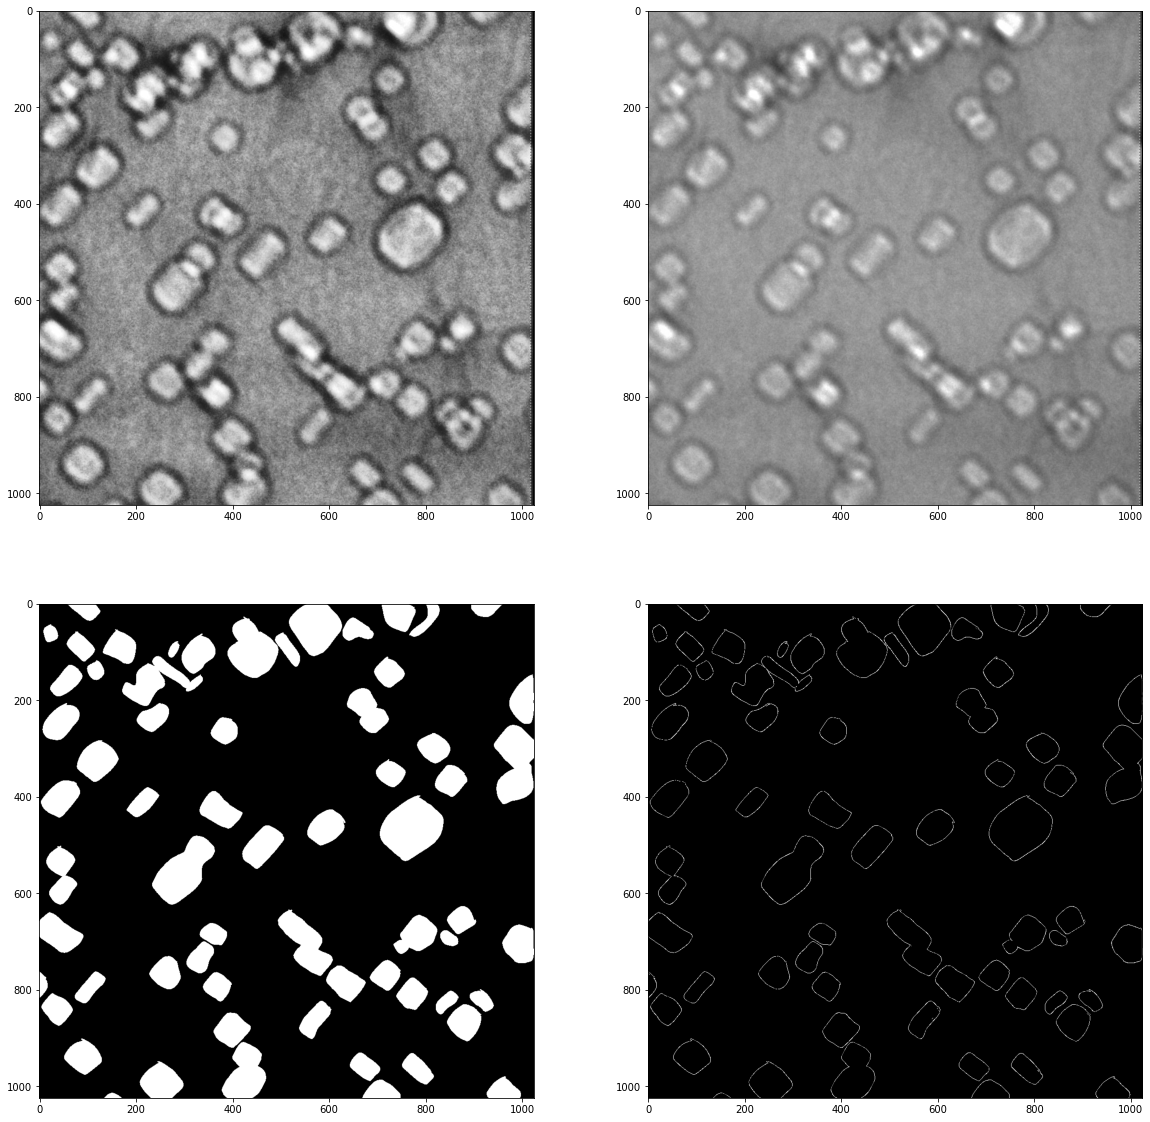

In [8]:


u,v,w,x = images.load_image_paths()
i = 3 ## random.randint(0, 15)
print(i)
x = images.load_image(u[i])
images.load_mask(v[i])
raw_image = cv2.imread(u[i])
raw_mask = cv2.imread(v[i], flags=cv2.IMREAD_GRAYSCALE)
non_binary_mask = (np.logical_and(raw_mask > 0, raw_mask < 255))*1.
plt.rcParams["figure.figsize"] = (20,20)
plt.figure()
f, axarr = plt.subplots(2, 2)
axarr[0][0].imshow(np.squeeze(x, axis=2), cmap = 'gray') 
axarr[0][1].imshow(raw_image, cmap = 'gray')
axarr[1][0].imshow(images.load_mask(v[i]).reshape((1024, 1024)), cmap = 'gray')
axarr[1][1].imshow(non_binary_mask.reshape((1024, 1024)), cmap = 'gray')
plt.show()

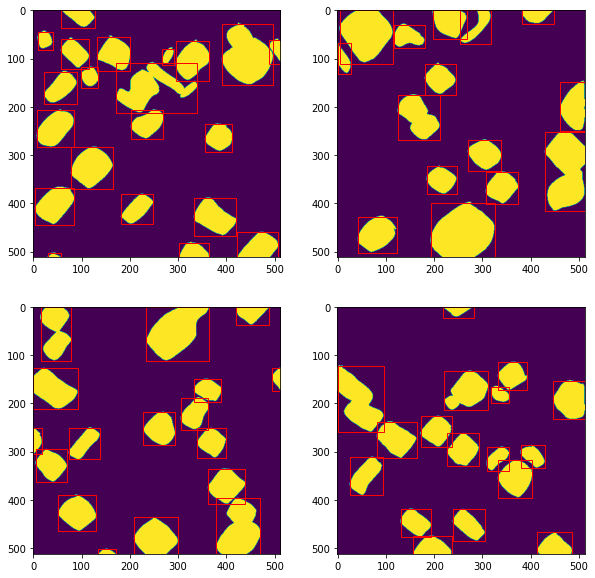

In [9]:
# Create figure and axes
plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots(2,2)

mask = images.split(images.load_mask(v[i]))[0][:,:,0]
bboxes = images.get_bboxes(mask)
# Display the image
ax[0][0].imshow(mask)
# Create a Rectangle patch
for bbox in bboxes:
  rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax[0][0].add_patch(rect)
mask = images.split(images.load_mask(v[i]))[1][:,:,0]
bboxes = images.get_bboxes(mask)
# Display the image
ax[0][1].imshow(mask)
# Create a Rectangle patch
for bbox in bboxes:
  rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax[0][1].add_patch(rect)
mask = images.split(images.load_mask(v[i]))[2][:,:,0]
bboxes = images.get_bboxes(mask)
# Display the image
ax[1][0].imshow(mask)
# Create a Rectangle patch
for bbox in bboxes:
  rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax[1][0].add_patch(rect)
mask = images.split(images.load_mask(v[i]))[3][:,:,0]
bboxes = images.get_bboxes(mask)
# Display the image
ax[1][1].imshow(mask)
# Create a Rectangle patch
for bbox in bboxes:
  rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax[1][1].add_patch(rect)
plt.show()

In [ ]:
K.clear_session()
## A simple backbone from a unet like architecture that is known to work well 
## with our data
class DownBlock(layers.Layer):
  def __init__(self, filters, bn=True, dropout=0.2):
    super(DownBlock, self).__init__()
    self.conv_1 = layers.Conv2D(filters, 3, padding="same", activation=layers.LeakyReLU()) 
    self.concat = layers.Concatenate()
    self.conv_2 = layers.Conv2D(filters, 3, padding="same", activation=layers.LeakyReLU())
    self.bn = None
    if bn:
      self.bn = layers.BatchNormalization()
    self.dropout = None
    if dropout > 0.0:
      self.dropout = layers.Dropout(dropout)
    self.mp = layers.MaxPooling2D(padding="valid")
  
  def call(self, inputs):
    t1 = self.conv_1(inputs)
    t2 = self.concat([inputs, t1])
    t2 = self.conv_2(t2)
    if self.dropout:
      t2 = self.dropout(t2)
    if self.bn:
      t2 = self.bn(t2)
    return self.mp(t2)

class Backbone(layers.Layer):
  def __init__(self):
    super(Backbone, self).__init__()
    self.down_1 = DownBlock(4)
    self.down_2 = DownBlock(8)
    self.down_3 = DownBlock(16)
    self.down_4 = DownBlock(32)
    self.down_5 = DownBlock(64)
  
  def call(self, inputs):
    x0 = self.down_1(inputs)
    x1 = self.down_2(x0)
    x2 = self.down_3(x1)
    x3 = self.down_4(x2)
    x4 = self.down_5(x3)
    return (x1, x2, x3, x4)

class UpsampleAndAdd(layers.Layer):
  def __init__(self):
    super(UpsampleAndAdd, self).__init__()
    self.conv = layers.Conv2D(256, (1,1))
    self.up = layers.Conv2DTranspose(256, 2, 2, padding="valid")
    self.add = layers.Add()
  def call(self, x, y):
    x1 = self.conv(x)
    y1 = self.up(y)
    return self.add([x1, y1])

## Feature pyramid layer
class Fpn(layers.Layer):
  def __init__(self):
    super(Fpn, self).__init__()
    self.conv_1 = layers.Conv2D(256, (1,1))
    self.ua_1 = UpsampleAndAdd()
    self.ua_2 = UpsampleAndAdd()
    self.ua_3 = UpsampleAndAdd()
    self.conv_2 = layers.Conv2D(256, (3,3), padding="same")
    self.conv_3 = layers.Conv2D(256, (3,3), padding="same")
    self.conv_4 = layers.Conv2D(256, (3,3), padding="same")
    self.conv_5 = layers.Conv2D(256, (3,3), padding="same")
    self.mp = layers.MaxPooling2D(pool_size=(1,1), strides=2)

  def call(self, x1, x2, x3, x4):
    y4 = self.conv_1(x4)
    y3 = self.ua_1(x3, y4)
    y2 = self.ua_2(x2, y3)
    y1 = self.ua_3(x1, y2)
    return (self.conv_2(y1), self.conv_3(y2), self.conv_4(y3), self.conv_5(y4), self.mp(y4))
x1, x2, x3, x4 = Backbone()(np.zeros((2,512, 512, 1)))
y1, y2, y3, y4, y5 = Fpn()(x1, x2, x3, x4)

## Region proposal network
def rpn(anchors_per_location=3, fpn_depth=256):
  ## let feature_map dims be S x S x 256
  feature_map = layers.Input(shape=[None, None, fpn_depth])
  ## shared.shape = (S, S, 512)
  shared = layers.Conv2D(512, (3, 3), padding='same', activation=layers.LeakyReLU(),
                      strides=1, name="rpn_shared")(feature_map)
  # Anchor Score. [batch, height, width, anchors per location * 2].
  # x.shape = (S, S, 6)
  x = layers.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation="softmax")(shared)
  # rpn_probs.shape = (S x S x 3, 2)
  rpn_probs = layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)

  # Bounding box refinement. [batch, H, W, anchors per location * 4]
  x = layers.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
              activation=layers.LeakyReLU(), name='rpn_bbox_pred')(shared)

  # rpn_bbox.shape = (S x S x 3, 4)
  rpn_bbox = layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)
  outputs = (rpn_probs, rpn_bbox)
  return keras.models.Model(feature_map, outputs)

In [10]:
x = utils.anchors([512, 512], [32,64,128], [0.5, 1., 2.], 16)
print(x.shape)
utils.clip_anchors(x)


(9216, 4)


<tf.Tensor: shape=(6792, 4), dtype=float32, numpy=
array([[  1.3725834,   4.6862917,  46.62742  ,  27.31371  ],
       [ 17.372583 ,   4.6862917,  62.62742  ,  27.31371  ],
       [ 33.37258  ,   4.6862917,  78.62742  ,  27.31371  ],
       ...,
       [378.74518  , 325.49033  , 469.25482  , 506.50967  ],
       [394.74518  , 325.49033  , 485.25482  , 506.50967  ],
       [410.74518  , 325.49033  , 501.25482  , 506.50967  ]],
      dtype=float32)>

In [ ]:
x = build_rpn_model()
x.summary()
keras.backend.clear_session()

NameError: ignored

In [ ]:
def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)] boxes to update
    deltas: [N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped
    
class ProposalLayer(KL.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.
    Inputs:
        rpn_probs: [batch, num_anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, num_anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, num_anchors, (y1, x1, y2, x2)] anchors in normalized coordinates
    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.proposal_count = proposal_count
        self.nms_threshold = 0.7

    def call(self, inputs):
        batch_size = inputs[0].shape[0]
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Anchors
        anchors = inputs[2]
        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]

        boxes = batch_slice([anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  batch_size,
                                  names=["refined_anchors"])

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  batch_size,
                                  names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(
                boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
            proposals = tf.pad(proposals, [(0, padding), (0, 0)])
            return proposals
        proposals = batch_slice([boxes, scores], nms, batch_size)
        return proposals

    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)

In [ ]:
class DetectionTargetLayer(layersLayer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.
    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type
    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.
    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

    def __init__(self, config, **kwargs):
        super(DetectionTargetLayer, self).__init__(**kwargs)
        self.config = config

    def call(self, inputs):
        proposals = inputs[0]
        gt_class_ids = inputs[1]
        gt_boxes = inputs[2]
        gt_masks = inputs[3]

        # Slice the batch and run a graph for each slice
        # TODO: Rename target_bbox to target_deltas for clarity
        names = ["rois", "target_class_ids", "target_bbox", "target_mask"]
        outputs = utils.batch_slice(
            [proposals, gt_class_ids, gt_boxes, gt_masks],
            lambda w, x, y, z: detection_targets_graph(
                w, x, y, z, self.config),
            self.config.IMAGES_PER_GPU, names=names)
        return outputs

    def compute_output_shape(self, input_shape):
        return [
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # rois
            (None, self.config.TRAIN_ROIS_PER_IMAGE),  # class_ids
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # deltas
            (None, self.config.TRAIN_ROIS_PER_IMAGE, self.config.MASK_SHAPE[0],
             self.config.MASK_SHAPE[1])  # masks
        ]

    def compute_mask(self, inputs, mask=None):
        return [None, None, None, None]


In [ ]:
## What does batch_slice do
t = tf.convert_to_tensor(np.random.randn(4, 3))
ix = tf.nn.top_k(t, 2, sorted=True).indices
print(t)
print(ix)
batch_slice([t, ix], lambda x, y: tf.gather(x, y), 2)

tf.Tensor(
[[-0.72178719 -0.12621701  0.17059008]
 [ 0.81531141  0.85252596 -0.21645062]
 [ 0.40437868  0.6521274   0.41926502]
 [ 0.80200095 -1.894487   -1.33180861]], shape=(4, 3), dtype=float64)
tf.Tensor(
[[2 1]
 [1 0]
 [1 2]
 [0 2]], shape=(4, 2), dtype=int32)


<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 0.17059008, -0.12621701],
       [ 0.85252596,  0.81531141]])>

In [ ]:
BATCH_SIZE = 2

class MaskRCNNTrainer(object):
  def __init__(self, model_dir, backbone):
    self.model_dir = model_dir
    self.backbone = backbone
    self.backbone_shapes = [128, 64, 32, 16, 8]
    # Cache anchors and reuse if image shape is the same
    self.anchors = norm_boxes(generate_pyramid_anchors(
            (32, 64, 128, 256, 512), ## RPN anchor scales
            [0.5, 1, 2], ## anchor aspect ratios
            self.backbone_shapes,
            512//self.backbone_shapes))

  def build(self, mode, batch_size = 2):
    input_image = layers.Input(
        shape=[512, 512, 1], name="input_image")    # RPN GT
    input_rpn_match = layers.Input(
        shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
    input_rpn_bbox = layers.Input(
        shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

    # Detection GT (class IDs, bounding boxes, and masks)
    # 1. GT Class IDs (zero padded)
    input_gt_class_ids = layers.Input(
        shape=[None], name="input_gt_class_ids", dtype=tf.int32)
    # 2. GT Boxes in pixels (zero padded)
    # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
    input_gt_boxes = layers.Input(
        shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
    # Normalize coordinates
    gt_boxes = layers.Lambda(lambda x: norm_boxes_graph(
        x, input_image.shape[1:3]))(input_gt_boxes)
    # 3. GT Masks (zero padded)
    # [batch, height, width, MAX_GT_INSTANCES]
    input_gt_masks = layers.Input(
        shape=[512, 512, None],
        name="input_gt_masks", dtype=bool)

    # Build the shared convolutional layers.
    # Bottom-up Layers
    # Returns a list of the last layers of each stage, 5 in total.
    # Don't create the thead (stage 5), so we pick the 4th item in the list.
    _, C2, C3, C4, C5 = self.backbone(input_image, config.BACKBONE,
                                          stage5=True, train_bn=config.TRAIN_BN)
    # Top-down Layers
    # TODO: add assert to varify feature map sizes match what's in config
    P5 = layersConv2D(256, (1, 1), name='fpn_c5p5')(C5)
    P4 = layersAdd(name="fpn_p4add")([
        layersUpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
        layersConv2D(256, (1, 1), name='fpn_c4p4')(C4)])
    P3 = layersAdd(name="fpn_p3add")([
        layersUpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
        layersConv2D(256, (1, 1), name='fpn_c3p3')(C3)])
    P2 = layersAdd(name="fpn_p2add")([
        layersUpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
        layersConv2D(256, (1, 1), name='fpn_c2p2')(C2)])
    # Attach 3x3 conv to all P layers to get the final feature maps.
    P2 = layersConv2D(256, (3, 3), padding="SAME", name="fpn_p2")(P2)
    P3 = layersConv2D(256, (3, 3), padding="SAME", name="fpn_p3")(P3)
    P4 = layersConv2D(256, (3, 3), padding="SAME", name="fpn_p4")(P4)
    P5 = layersConv2D(256, (3, 3), padding="SAME", name="fpn_p5")(P5)
    # P6 is used for the 5th anchor scale in RPN. Generated by
    # subsampling from P5 with stride of 2.
    P6 = layersMaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

    # Note that P6 is used in RPN, but not in the classifier heads.
    rpn_feature_maps = [P2, P3, P4, P5, P6]
    mrcnn_feature_maps = [P2, P3, P4, P5]

    anchors = self.anchors
    # Duplicate across the batch dimension because Keras requires it
    # TODO: can this be optimized to avoid duplicating the anchors?
    anchors = np.broadcast_to(anchors, (batch_size,) + anchors.shape)
    class ConstLayer(tf.keras.layers.Layer):
        def __init__(self, x, name=None):
            super(ConstLayer, self).__init__(name=name)
            self.x = tf.Variable(x)

        def call(self, input):
            return self.x

    anchors = ConstLayer(anchors, name="anchors")(input_image)

    # RPN Model
    rpn = build_rpn_model()
    # Loop through pyramid layers
    layer_outputs = []  # list of lists
    for p in rpn_feature_maps:
        layer_outputs.append(rpn([p]))
    # Concatenate layer outputs
    # Convert from list of lists of level outputs to list of lists
    # of outputs across levels.
    # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
    output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
    outputs = list(zip(*layer_outputs))
    outputs = [layersConcatenate(axis=1, name=n)(list(o))
                for o, n in zip(outputs, output_names)]

    rpn_class_logits, rpn_class, rpn_bbox = outputs

    # Generate proposals
    # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
    # and zero padded.
    proposal_count = 2000
    rpn_rois = ProposalLayer(
        proposal_count=proposal_count,
        name="ROI")([rpn_class, rpn_bbox, anchors])


    active_class_ids = input_gt_class_ids

    target_rois = rpn_rois

    # Generate detection targets
    # Subsamples proposals and generates target outputs for training
    # Note that proposal class IDs, gt_boxes, and gt_masks are zero
    # padded. Equally, returned rois and targets are zero padded.
    # NOTE: target_bbox is actually delta, not a bbox
    rois, target_class_ids, target_bbox, target_mask =\
        DetectionTargetLayer(config, name="proposal_targets")([
            target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

    # Network Heads
    # TODO: verify that this handles zero padded ROIs
    mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
        fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                              config.POOL_SIZE, config.NUM_CLASSES,
                              train_bn=config.TRAIN_BN,
                              fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

    mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                      input_image_meta,
                                      config.MASK_POOL_SIZE,
                                      config.NUM_CLASSES,
                                      train_bn=config.TRAIN_BN)

    # TODO: clean up (use tf.identify if necessary)
    output_rois = layersLambda(lambda x: x * 1, name="output_rois")(rois)

    # Losses
    rpn_class_loss = layersLambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
        [input_rpn_match, rpn_class_logits])
    rpn_bbox_loss = layersLambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
        [input_rpn_bbox, input_rpn_match, rpn_bbox])
    class_loss = layersLambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
        [target_class_ids, mrcnn_class_logits, active_class_ids])
    bbox_loss = layersLambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
        [target_bbox, target_class_ids, mrcnn_bbox])
    mask_loss = layersLambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
        [target_mask, target_class_ids, mrcnn_mask])

    # Model
    inputs = [input_image, input_image_meta,
              input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
    outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                rpn_rois, output_rois,
                rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
    model = KM.Model(inputs, outputs, name='mask_rcnn')
    return model

In [302]:
importlib.reload(images)
images.compute_and_write_bboxes(in_path = '/content/drive/MyDrive/Segmentation/dataset/test')
images.compute_and_write_bboxes(in_path = '/content/drive/MyDrive/Segmentation/dataset/train')
images.compute_and_write_bboxes(in_path = '/content/drive/MyDrive/Segmentation/dataset/holdout')
dataset_path = '/content/drive/MyDrive/Segmentation/dataset'
def name(path):
  return os.path.splitext(os.path.basename(path))[0]

train_images = sorted(glob(os.path.join(dataset_path, 'train', 'images/*.png')))
train_masks = sorted(glob(os.path.join(dataset_path, 'train', 'masks/*.png')))
train_bboxes = sorted(glob(os.path.join(dataset_path, 'train', 'bboxes/*.txt')))
test_images = sorted(glob(os.path.join(dataset_path, 'test', 'images/*.png')))
test_masks = sorted(glob(os.path.join(dataset_path, 'test', 'masks/*.png')))
test_bboxes = sorted(glob(os.path.join(dataset_path, 'test', 'bboxes/*.txt')))
holdout_images = sorted(glob(os.path.join(dataset_path, 'holdout', 'images/*.png')))
holdout_masks = sorted(glob(os.path.join(dataset_path, 'holdout', 'masks/*.png')))
holdout_bboxes = sorted(glob(os.path.join(dataset_path, 'holdout', 'bboxes/*.txt')))

print(len(train_images))
print(len(train_masks))
print(len(train_bboxes))
print(len(test_images))
print(len(test_masks))
print(len(test_bboxes))
print(len(holdout_images))
print(len(holdout_masks))
print(len(holdout_bboxes))
assert(len(train_images) == 1024)
assert(len(test_images) == 32)
assert(len(holdout_images) == 32)

def names(paths):
  return [name(p) for p in paths]

assert(names(train_images) == names(train_masks))
assert(names(train_masks) == names(train_bboxes))
assert(names(test_images) == names(test_masks))
print(test_masks)
print(test_bboxes)
assert(names(test_masks) == names(test_bboxes))
assert(names(holdout_images) == names(holdout_masks))
assert(names(holdout_masks) == names(holdout_bboxes))



/content/drive/MyDrive/Segmentation/dataset/test/masks/100kX_300kV_0636_7_0.png
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0636_7_0.tf
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0636_7_0.txt
/content/drive/MyDrive/Segmentation/dataset/test/masks/100kX_300kV_0651_16_1.png
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0651_16_1.tf
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0651_16_1.txt
/content/drive/MyDrive/Segmentation/dataset/test/masks/100kX_300kV_0651_7_0.png
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0651_7_0.tf
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0651_7_0.txt
/content/drive/MyDrive/Segmentation/dataset/test/masks/100kX_300kV_0537_15_1.png
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0537_15_1.tf
/content/drive/MyDrive/Segmentation/dataset/test/bboxes/100kX_300kV_0537_15_1.txt
/content/drive/MyDrive/Segment

AssertionError: ignored

In [38]:
images.read_split_augment_and_write_all_images(x, y, out_dir)

/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_0.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_1.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_2.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_3.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_4.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_5.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_6.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_7.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_8.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_9.png
/content/drive/MyDrive/Segmentation/dataset/train/images/100kX_300kV_0537.tiff_1_10.png
/content/drive/MyDrive/Segmentation/datase